<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cifar10_linear_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install self_supervised
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import kornia.augmentation as korniatfm
import torchvision.transforms as tvtfm
from fastcore.test import *
import torch
device='cuda' if torch.cuda.is_available() else 'cpu'
cuda=(device=='cuda')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 518 kB/s 
     |████████████████████████████████| 548 kB 7.3 MB/s 
     |████████████████████████████████| 551 kB 77.9 MB/s 
     |████████████████████████████████| 163 kB 72.6 MB/s 


Ok, let's try training a linear classifier on CIFAR10, using the FastAI `learn` API via copy-pasting from BarlowTwins self_supervised as needed. We want to include RandomResizedCrop, on the GPU etc.

In [2]:
n_in=3
size=128
bs=512
path = untar_data(URLs.CIFAR)

fnames = get_image_files(path / "train")

def label_func(fname):
    return fname.name.split('_')[1].strip('png').strip('.')
    
labels = [label_func(fname) for fname in fnames]

dls = ImageDataLoaders.from_lists(path, fnames, labels,bs=bs, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.5,num_workers=12,device=device,seed=42)

#dls.valid = None
set(labels) #Check that the labels make sense

{'airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck'}

Let's make sure that the random seed is working as expected. Please note that we need to call `seed_everything` first.

In [ ]:
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
#First test of random seed
seed_everything(seed=42)
dls = ImageDataLoaders.from_lists(path, fnames, labels,bs=500,valid_pct=0.99,num_workers=12*(cuda=='cuda'),device=device,seed=42)
x,y = dls.train.one_batch()
x = x.sum().item()
test_eq(x,727058.625) #when seed = 42

#Second test of random seed
seed_everything(seed=42)
dls = ImageDataLoaders.from_lists(path, fnames, labels,bs=500,valid_pct=0.98,num_workers=12*(cuda=='cuda'),device=device,seed=42)
S=0
for x,y in dls.train:
    S+=x.sum().item()

test_eq(S,1437396.5625) #When seed=42

In [5]:
#Batch level augmentations for linear classifier. At present time, just RandomResizedCrop and Normalization.
def get_batch_augs(size,
                    resize_scale=(0.08, 1.0),resize_ratio=(3/4, 4/3),
                    stats=None,cuda=default_device().type == 'cuda',xtra_tfms=[]):
    
    "Input batch augmentations implemented in tv+kornia+fastai"
    tfms = []
    tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]
    tfms += xtra_tfms
    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

In [6]:
#Linear model 
class LinearModel(Module):
    """Linear model
    """
    def __init__(self,indim,outdim=10):
        self.L = nn.Linear(indim,outdim)
        self.relu = nn.ReLU()
        
    def forward(self,x): 
            x=self.L(x.view(x.shape[0],-1))
            return x

In [26]:
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self,aug_pipelines,n_in, show_batch=False, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1= aug_pipelines[0]
        self.aug2=Pipeline( split_idx = 0) #empty pipeline
        if print_augs: print(self.aug1), print(self.aug2)
        self.n_in=n_in
        self._show_batch=show_batch
        self.criterion = nn.CrossEntropyLoss()

    def before_fit(self): 
        self.learn.loss_func = self.lf
            
    def before_batch(self):

        if self.n_in == 1:
            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))                            
        elif self.n_in == 3:
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
        self.learn.xb = (xi,)

        if self._show_batch:
            self.learn.aug_x = torch.cat([xi, xj])

    def lf(self, pred, *yb):        
        loss=self.criterion(pred,self.y)
        return loss

    @torch.no_grad()
    def show(self, n=1):
        if self._show_batch==False:
            print('Need to set show_batch=True')
            return
        bs = self.learn.aug_x.size(0)//2
        x1,x2  = self.learn.aug_x[:bs], self.learn.aug_x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)



Now let's setup the data, model, learner etc and visualize the augmentations used. First setup:

In [30]:
#hyperparameters
n_in=3
size=128
seed=42

#data
seed_everything(seed=42)
dls = ImageDataLoaders.from_lists(path, fnames, labels,
                                  item_tfms=[Resize(size=size)],bs=1024,valid_pct=0.5,
                                  num_workers=12*(cuda=='cuda'),device=device,seed=42
                                  )


#model, aug_pipeline 'callback' (what do we call this?) and learner
model = LinearModel(indim=size*size*3)
aug_pipelines = [get_batch_augs(size=size,stats=cifar_stats,resize_scale=(0.3, 1.0))]
bt = BarlowTwins(aug_pipelines,show_batch=True,n_in=n_in,print_augs=True)
learn = Learner(dls,model, cbs=[bt],metrics=accuracy)

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: 


Now let's visualize the augmentations used:

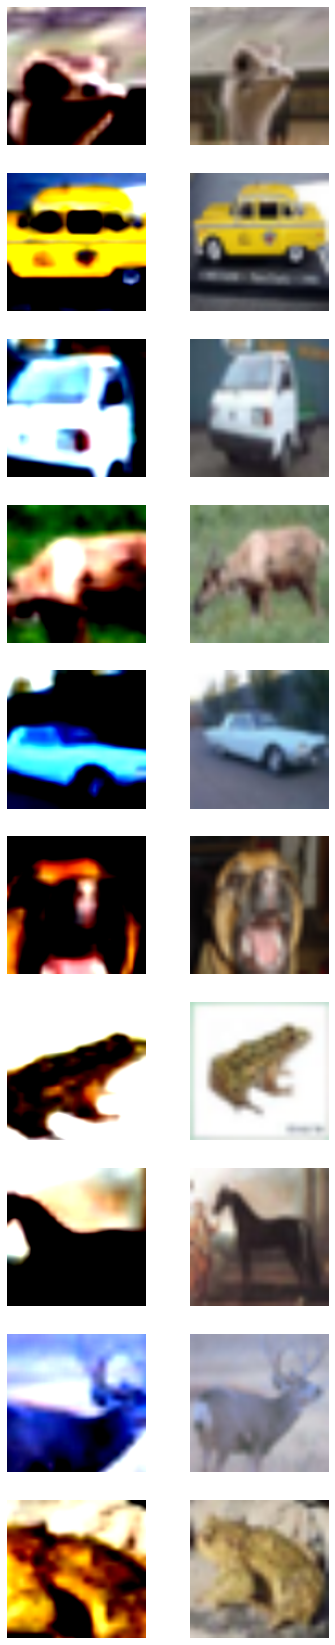

In [28]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=10)

Fit the model:

In [31]:
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,7.913767,5.021847,0.188320,01:29
1,5.408547,3.166464,0.245840,01:28
2,4.263451,3.115170,0.263600,01:29
